# Plot model fits for simulation analysis 2

In [43]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from psifr import fr
from mindstorm import statplot
from cymr import cmr
from cfr import framework
from cfr import figures
from cfr import task

res_dir = Path(os.environ['CFR_RESULTS'])
fit_dir = Path(os.environ['CFR_FITS'])
fig_dir = Path(os.environ['CFR_FIGURES']) / 'sim2'

data_file = res_dir / 'cfr_eeg_mixed.csv'
patterns_file = res_dir / 'cfr_patterns.hdf5'
os.makedirs(fig_dir, exist_ok=True)
figures.set_style()

In [111]:
res_dir

PosixPath('/Users/morton/Dropbox/work/cmr_cfr/cfr')

## Read observed and simulated data

In [2]:
patterns = cmr.load_patterns(patterns_file)
rsm = patterns['similarity']['use']

In [31]:
models = [
    'cmrs_fcf-loc-cat-use',
    'cmrs_fcf-loc-cat-use_sl-B_enc-B_rec_fix-B_rec_cat1-B_rec_use1',
    'cmrs_fcf-loc-cat-use_sl-B_enc-B_rec_fix-B_enc_use1-B_rec_cat1-B_rec_use1',
]
model_names = [
    'DCMR',
    'DCMR-Restricted',
    'DCMR-Restricted2',
]
data = framework.read_model_sims(data_file, fit_dir, models, model_names)

In [32]:
# for speed, omit simulation replications; comment out for final
# data = data.loc[data['list'] <= 48]

## Set colors

In [33]:
curve = sns.color_palette(
    'ch:rot=-.5, light=.6, dark=.3, gamma=1', n_colors=len(models)
)
curve.insert(len(models), (.3, .3, .3))
curve

[(0.44163916703794076, 0.6914342033666265, 0.5414714890673176),
 (0.27424883716016524, 0.5352555384607786, 0.4809527643729599),
 (0.17051215858853222, 0.344636926092434, 0.3959064384004337),
 (0.3, 0.3, 0.3)]

In [34]:
dark = sns.color_palette(
    'ch:rot=-.5, light=.7, dark=.3, gamma=.6', n_colors=len(models)
)
dark.insert(len(models), (.6, .6, .6))
dark

[(0.725301473503126, 0.8645990769601404, 0.7363315007817791),
 (0.5016677447743987, 0.7426793533080586, 0.6602162691374847),
 (0.33145894574681245, 0.5393097642399239, 0.6005096167923277),
 (0.6, 0.6, 0.6)]

In [35]:
light = sns.color_palette(
    'ch:rot=-.5, light=.7, dark=.3, gamma=.2', n_colors=len(models)
)
light.insert(len(models), (.85, .85, .85))
light

[(0.8973525746116884, 0.9546730560357413, 0.901891392639006),
 (0.7912737188119296, 0.9119907090651371, 0.870686908851388),
 (0.6820851323976215, 0.8225675908928259, 0.8639314200489312),
 (0.85, 0.85, 0.85)]

In [36]:
opt = {'height': 4, 'aspect': 1, 'palette': curve}

In [61]:
from psifr import transitions
import importlib
importlib.reload(fr)
importlib.reload(transitions)
drw = data.groupby('source').apply(
    fr.distance_rank_window, 
    'item_index', 
    1 - rsm, 
    np.array([-1, 0, 1]),
    test_key='category', 
    test=lambda x, y: x == y,
)

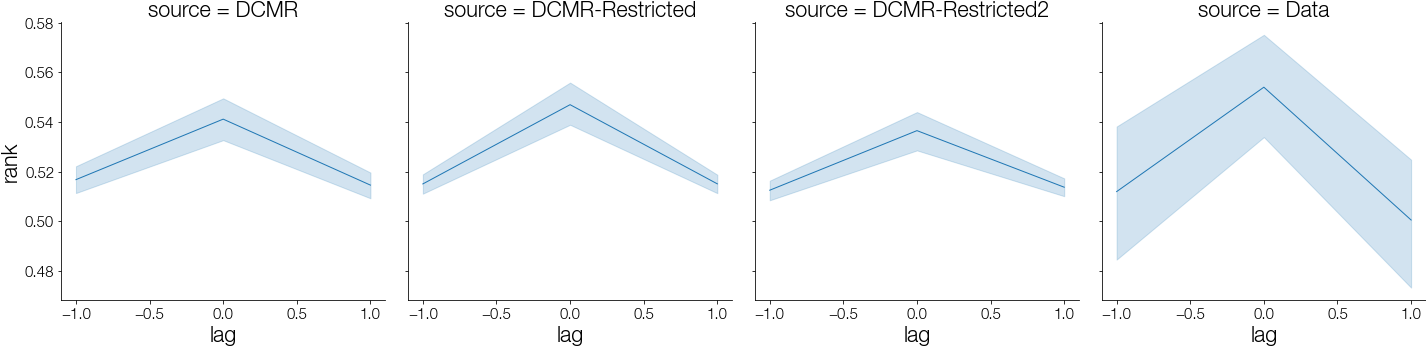

In [62]:
sns.relplot(data=drw, x="lag", y="rank", col="source", kind="line")

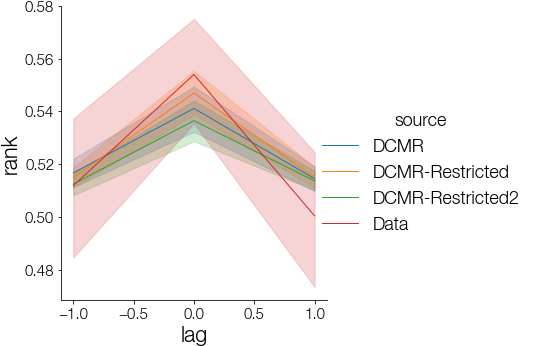

In [108]:
sns.relplot(data=drw, x="lag", y="rank", hue="source", kind="line")

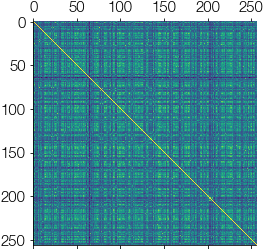

In [105]:
import scipy.spatial.distance as sd
mat = rsm[:256, :256]
plt.matshow(mat)

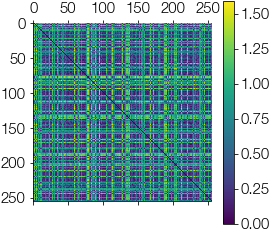

In [107]:
plt.matshow(sd.squareform(sd.pdist(mat, 'correlation')))
plt.colorbar()

In [100]:
lags = drw.unstack("lag").loc[:, "rank"]
diff = lags[-1] - lags[1]
p = diff.unstack('source')
pd.DataFrame({c: pg.ttest(p[c], 0).iloc[0] for c in p.columns})

,DCMR,DCMR-Restricted,DCMR-Restricted2,Data
T,0.891144,-0.015549,-0.67507,0.705926
dof,28,28,28,28
alternative,two-sided,two-sided,two-sided,two-sided
p-val,0.380446,0.987705,0.505168,0.486067
CI95%,"[-0.0, 0.01]","[-0.0, 0.0]","[-0.0, 0.0]","[-0.02, 0.04]"
cohen-d,0.165481,0.002887,0.125357,0.131087
BF10,0.284,0.197,0.243,0.248
power,0.138257,0.050026,0.099971,0.104749


In [46]:
importlib.reload(task)
dra = data.groupby('source').apply(
    task.distance_rank_asym, 
    'item_index', 
    1 - rsm, 
    test_key='category', 
    test=lambda x, y: x == y,
)

In [94]:
p = pd.pivot(data=dra.reset_index(), index='subject', columns='source', values='rank')
pd.DataFrame({c: pg.ttest(p[c], 0).iloc[0] for c in p.columns})

,DCMR,DCMR-Restricted,DCMR-Restricted2,Data
T,-0.891144,0.015549,0.67507,-0.705926
dof,28,28,28,28
alternative,two-sided,two-sided,two-sided,two-sided
p-val,0.380446,0.987705,0.505168,0.486067
CI95%,"[-0.01, 0.0]","[-0.0, 0.0]","[-0.0, 0.0]","[-0.04, 0.02]"
cohen-d,0.165481,0.002887,0.125357,0.131087
BF10,0.284,0.197,0.243,0.248
power,0.138257,0.050026,0.099971,0.104749


In [88]:
def run_ttest(x, y, **kwargs):
    stats = pg.ttest(x, y, **kwargs)
    return stats.loc['T-test'].to_list()

p = pd.pivot(data=dra.reset_index(), index='subject', columns='source', values='rank')
#p.apply(run_ttest, args=(0, ), axis=1, raw=True, result_type='expand')
p.transform(run_ttest, args=(0, ))

ValueError: Transform function failed

In [60]:
%pdb off
p = pd.pivot(data=dra.reset_index(), index='subject', columns='source', values='rank')
pg.ttest(p['DCMR-Restricted2'], 0)

Automatic pdb calling has been turned OFF


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.67507,28,two-sided,0.505168,"[-0.0, 0.0]",0.125357,0.243,0.099971


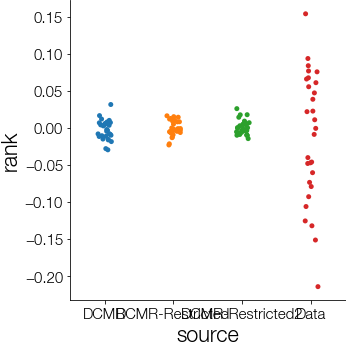

In [50]:
sns.catplot(data=dra.reset_index(), x="source", y="rank")

## Serial position effects

In [9]:
spc = data.groupby('source').apply(fr.spc)

LINO NOT subset; don't know how to subset; dropped


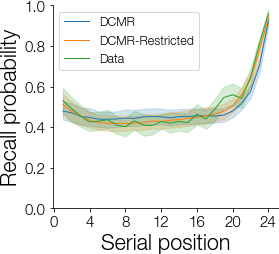

In [10]:
g = fr.plot_spc(spc, hue='source', height=4, aspect=1.1)
g.set(xticks=[0, 4, 8, 12, 16, 20, 24])
g.axes[0, 0].legend(fontsize='x-small')
g.savefig(fig_dir / 'spc_comp.pdf')

In [11]:
pnr = data.groupby('source').apply(fr.pnr)

LINO NOT subset; don't know how to subset; dropped
LINO NOT subset; don't know how to subset; dropped


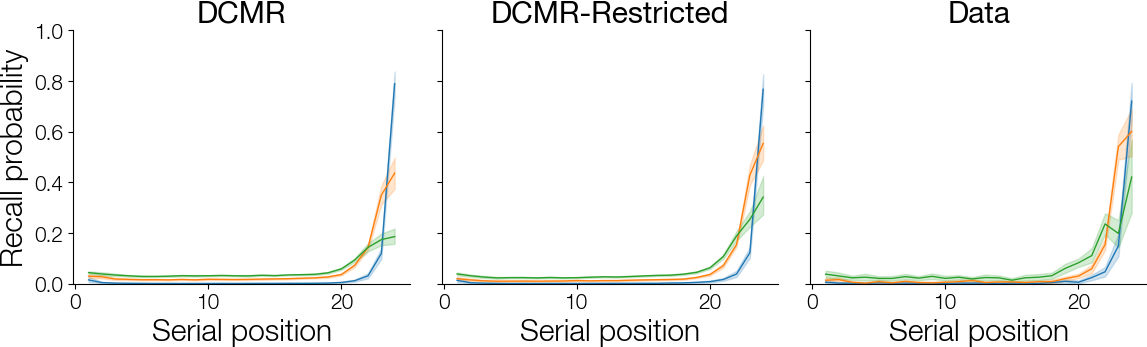

In [12]:
g = fr.plot_spc(
    pnr.query('output <= 3'), hue='output', col='source', height=4, aspect=1
)
g.set_titles('{col_name}')
g.savefig(fig_dir / 'pnr.pdf');

## Clustering measures

In [24]:
lag_rank_within = data.groupby('source').apply(
    fr.lag_rank, test_key='category', test=lambda x, y: x == y
)

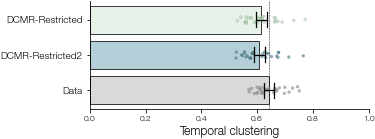

In [25]:
fig, ax = plt.subplots(figsize=(5, 2))
statplot.plot_swarm_bar(
    lag_rank_within,
    y='source',
    x='rank',
    dark=dark,
    light=light,
    point_kind='strip',
    ax=ax,
)
ax.tick_params(axis='x', labelsize='small')
ax.tick_params(axis='y', labelsize='medium')
m = lag_rank_within.loc['Data', 'rank'].mean()
ax.axline([m, 0], slope=np.inf, linestyle='--', linewidth=.5, color='k')
ax.set(xlim=(0, 1), xlabel='Temporal clustering', ylabel='');
#fig.savefig(fig_dir / 'comp_lag_rank.pdf')

In [26]:
cat_crp = data.groupby('source').apply(
    fr.category_crp, category_key='category'
)

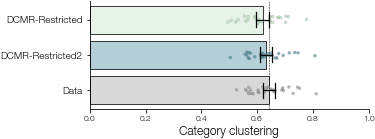

In [27]:
fig, ax = plt.subplots(figsize=(5, 2))
statplot.plot_swarm_bar(
    cat_crp,
    y='source',
    x='prob',
    dark=dark,
    light=light,
    point_kind='strip',
    ax=ax,
)
ax.tick_params(axis='x', labelsize='small')
ax.tick_params(axis='y', labelsize='medium')
m = cat_crp.loc['Data', 'prob'].mean()
ax.axline([m, 0], slope=np.inf, linestyle='--', linewidth=.5, color='k')
ax.set(xlim=(0, 1), xlabel='Category clustering', ylabel='');
#fig.savefig(fig_dir / 'comp_cat_crp.pdf')

In [28]:
use_rank = data.groupby('source').apply(
    fr.distance_rank, 'item_index', 1 - rsm, test_key='category',
    test=lambda x, y: x == y
)

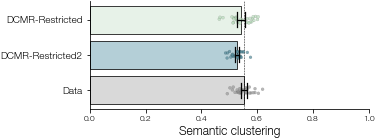

In [29]:
fig, ax = plt.subplots(figsize=(5, 2))
statplot.plot_swarm_bar(
    use_rank,
    y='source',
    x='rank',
    dark=dark,
    light=light,
    point_kind='strip',
    ax=ax,
)
ax.tick_params(axis='x', labelsize='small')
ax.tick_params(axis='y', labelsize='medium')
m = use_rank.loc['Data', 'rank'].mean()
ax.axline([m, 0], slope=np.inf, linestyle='--', linewidth=.5, color='k')
ax.set(xlim=(0, 1), xlabel='Semantic clustering', ylabel='');
#fig.savefig(fig_dir / 'comp_use_rank.pdf')

## Shifted distance rank

In [22]:
distances = 1 - rsm
max_shift = 3
dist_rank = data.groupby('source').apply(
    fr.distance_rank_shifted, 
    'item_index', 
    distances, 
    max_shift, 
    test_key='category', 
    test=lambda x, y: x == y,
)

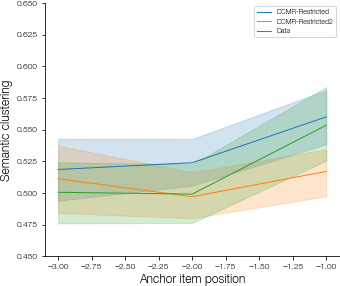

In [23]:
g = sns.relplot(
    data=dist_rank.reset_index(), 
    x='shift', 
    y='rank', 
    hue='source', 
    kind='line', 
    height=4,
    aspect=1.2,
)
ax = g.axes[0, 0]
g._legend.remove()
g.set(ylim=[.45, .65], ylabel='Semantic clustering', xlabel='Anchor item position')
ax.legend(fontsize='x-small')
# g.savefig(fig_dir / 'use_rank_shifted_comp.pdf')

In [21]:
subs = dist_rank.loc['Data']
shift_mat = pd.pivot(
    subs.reset_index(), index='subject', columns='shift', values='rank'
)
pg.ttest(shift_mat[-2], shift_mat[-3])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.086707,56,two-sided,0.931213,"[-0.04, 0.03]",0.02277,0.267,0.050833


In [22]:
subs = dist_rank.loc['DCMR']
shift_mat = pd.pivot(
    subs.reset_index(), index='subject', columns='shift', values='rank'
)
pg.ttest(shift_mat[-2], shift_mat[-3])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.66365,56,two-sided,0.101769,"[-0.0, 0.01]",0.436896,0.837,0.372816


In [23]:
subs = dist_rank.loc['DCMR-Restricted']
shift_mat = pd.pivot(
    subs.reset_index(), index='subject', columns='shift', values='rank'
)
pg.ttest(shift_mat[-2], shift_mat[-3])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.389629,56,two-sided,0.698289,"[-0.01, 0.01]",0.102321,0.284,0.066967


## Compound lag-CRP

In [24]:
crp = data.groupby('source').apply(
    fr.lag_crp_compound, test_key='category', test=lambda x, y: x == y
)
binned = crp.reset_index()
binned.loc[binned['previous'].abs() > 3, 'Previous'] = '|Lag|>3'
binned.loc[binned['previous'] == 1, 'Previous'] = 'Lag=+1'
binned.loc[binned['previous'] == -1, 'Previous'] = 'Lag=-1'
summed = binned.groupby(
    ['source', 'subject', 'Previous', 'current']
)[['actual', 'possible']].sum()
summed['prob'] = summed['actual'] / summed['possible']

LINO NOT subset; don't know how to subset; dropped
LINO NOT subset; don't know how to subset; dropped


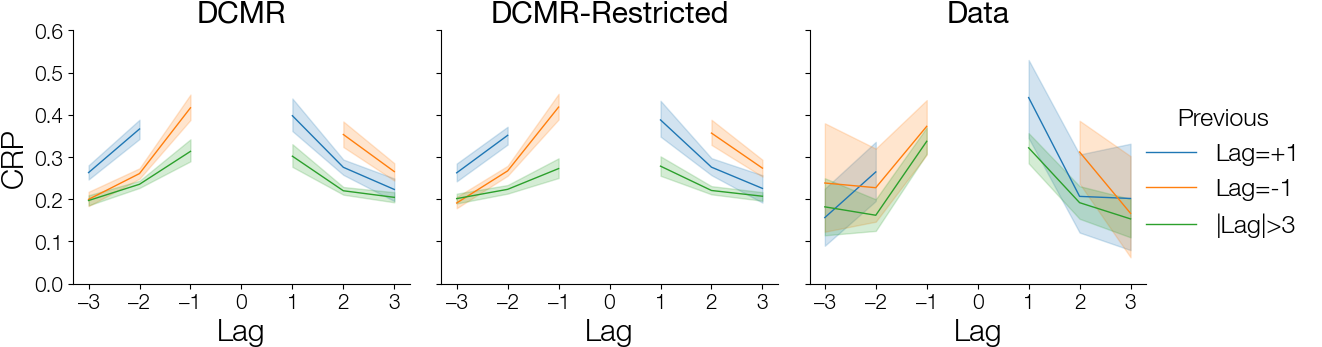

In [25]:
g = fr.plot_lag_crp(
    summed, lag_key='current', hue='Previous', col='source', height=4, max_lag=3
).add_legend()
g.set_titles(template='{col_name}')
g.set(ylim=[0, 0.6], xticks=[-3, -2, -1, 0, 1, 2, 3])
# g.savefig(fig_dir / 'lag_crp_compound.pdf');

### Test for compound cuing in data

In [26]:
subs = summed.loc['Data']
p1 = subs.loc[:, 'Lag=+1', :] - subs.loc[:, '|Lag|>3', :]
pg.ttest(p1[['prob']].query('current == 1')['prob'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.274438,27,two-sided,0.031101,"[0.01, 0.23]",0.429828,1.798,0.592181


In [27]:
n1 = subs.loc[:, 'Lag=-1', :] - subs.loc[:, '|Lag|>3', :]
pg.ttest(n1[['prob']].query('current == -1')['prob'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.937131,28,two-sided,0.356705,"[-0.04, 0.11]",0.174021,0.295,0.147867


### Test for compound cuing in DCMR-Restricted

In [28]:
subs = summed.loc['DCMR-Restricted']
p1 = subs.loc[:, 'Lag=+1', :] - subs.loc[:, '|Lag|>3', :]
pg.ttest(p1[['prob']].query('current == 1')['prob'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,10.357047,28,two-sided,4.411672e-11,"[0.09, 0.13]",1.923255,2.165e+08,1.0


In [29]:
n1 = subs.loc[:, 'Lag=-1', :] - subs.loc[:, '|Lag|>3', :]
pg.ttest(n1[['prob']].query('current == -1')['prob'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,13.968954,28,two-sided,3.818579e-14,"[0.12, 0.17]",2.59397,1.778e+11,1.0


In [30]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 8.4.0

numpy     : 1.21.4
seaborn   : 0.11.2
cfr       : 0.1.0
mindstorm : 0.8.1
pingouin  : 0.5.1
cymr      : 0.11.2
matplotlib: 3.5.2
psifr     : 0.8.0
pandas    : 1.4.2

